In [1]:
# Necessary libraries
import numpy as np
import math
import matplotlib.pyplot as plt
from typing import Callable, NamedTuple, List

In [2]:
true_result = (201 - math.cos(20) - 20*math.sin(20))/400 # True definite integral
plt.rcParams['figure.dpi'] = 120 # Plot size

# (a) Integrand

In [3]:
def f(x:float) -> float:
    """
    The function we are integrating.
    """
    s = math.sin(math.sqrt(100*x))
    fun = s*s # A bit faster than s**2
    return fun

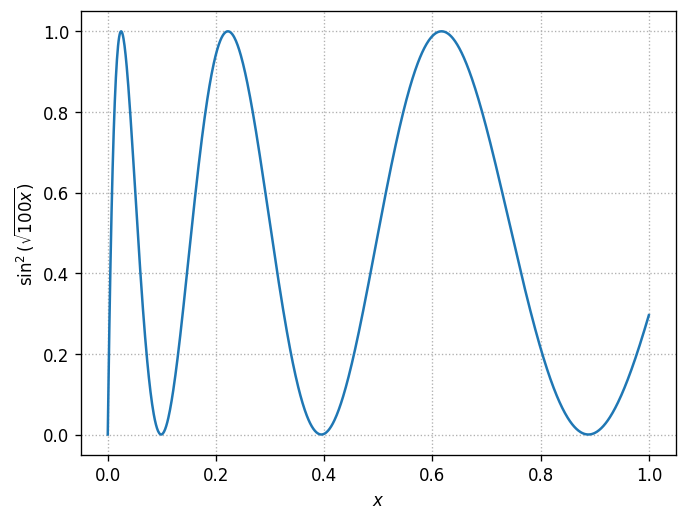

In [4]:
xs = np.linspace(0,1,1001)
funs = np.array([f(x) for x in xs])
plt.plot(xs, funs)
plt.xlabel(r"$x$")
plt.ylabel(r"$\sin^2\left(\sqrt{100 x}\right)$")
plt.grid(True, which='both', ls=':')
plt.show()

# (b) Adaptive trapezoidal

In [5]:
class TrapezoidResult(NamedTuple):
    """
    A typed container for the result of adaptive trapezoidal integration.
    """
    estimate : float         # Final trapezoid estimate of the integral
    error_est : float            # Final error estimate |I_curr - I_prev| / 3
    n_subintervals : int     # Final number of subintervals

In [6]:
def adaptive_trapezoid(
    f : Callable[[float], float],
    a : float,
    b : float,
    tol : float = 1e-6,
    max_refinements : int = 40,
) -> TrapezoidResult:
    """
    Approximates the definite integral of f from a to b by adaptive trapezoidal integration.

    Inputs:
    f : Callable[[float], float]   # Integrand on [a, b]
    a : float                      # Lower limit
    b : float                      # Upper limit
    tol : float                    # Target absolute tolerance on |I_new - I_old| / 3
    max_refinements : int          # Max number of global refinements

    Outputs:
    TrapezoidResult
        estimate : float           # Final estimate
        error_est : float              # Step-doubling error estimate at final iteration
        n_subintervals : int       # Number of subintervals in final mesh
    """
    if not(a < b):
        raise ValueError("Require a < b.")
    if not(tol > 0.0):
        raise ValueError("Require tol > 0.")
    if max_refinements < 1:
        raise ValueError("Require max_refinements >= 1.")

    # Initial estimate
    n_sub = 1
    h = b - a
    I = h * 0.5 * (f(a) + f(b))

    for _ in range(max_refinements):
        # Refine mesh
        n_sub *= 2
        h *= 0.5

        # Sum f at new midpoints of old subintervals
        sum_mid = 0.0
        for k in range(1, n_sub, 2):
            xk = a + (k*h) 
            sum_mid += f(xk)
            
        # Recycle old estimate
        I_new = (0.5 * I) + (h * sum_mid)

        # Make error estimate
        error_est = abs(I_new - I)/3.0
        if error_est < tol:
            return TrapezoidResult(I_new, error_est, n_sub)

        # Setup next refinement
        I = I_new
        
    return TrapezoidResult(I, error_est, n_sub)

In [7]:
trapezoid_result = adaptive_trapezoid(f, 0, 1, 1e-6)
print(f"The integral is {trapezoid_result.estimate} with an estimated error of {trapezoid_result.error_est} on a mesh with {trapezoid_result.n_subintervals} sub-intervals.")

The integral is 0.455832058278271 with an estimated error of 4.74025541467397e-07 on a mesh with 4096 sub-intervals.


# (c) Romberg

In [8]:
class RombergResult(NamedTuple):
    """
    A typed container for the result of Romberg integration.
    """
    estimate: float              # Final Romberg estimate R_{i,i}
    error_est: float                 # Final error estimate
    n_subintervals: int          # N_i at termination
    table: List[List[float]]     # Romberg table (rows i=1..k, columns m=1..i)

In [9]:
def romberg(
    f : Callable[[float], float],
    a : float,
    b : float,
    tol : float = 1e-6,
    max_levels : int = 40
) -> RombergResult:
    """
    Approximates the definite integral of f from a to b via Romberg integration.

    Inputs:
    f : Callable[[float], float]   # Integrand on [a, b]
    a : float                      # Lower limit
    b : float                      # Upper limit
    tol : float                    # Target absolute tolerance on |I_new - I_old| / 3
    max_levels : int               # Max number of rows

    Outputs:
    RombergResult
        estimate : float           # Final estimate
        error_est : float          # Step-doubling error estimate at final iteration
        n_subintervals : int       # Number of subintervals in final mesh
        table : List[List[float]]  # Table of estimates
    """
    if not(a < b):
        raise ValueError("Require a < b.")
    if not(tol > 0.0):
        raise ValueError("Require tol > 0.")
    if max_levels < 1:
        raise ValueError("Require max_levels >= 1.")

    # i = 1 (single trapezoid)
    h = b - a
    I_prev = 0.5 * h * (f(a) + f(b)) # I_1 or R_{1,1}
    table : List[List[float]] = [[I_prev]]
    n_sub = 1 # Number of sub-intervals
    error_est = float("inf")

    # Go down the rows i = 2..max_levels
    for i in range(2, max_levels + 1):
        # Refine mesh
        n_sub *= 2
        h *= 0.5
        
        # Sum f at new midpoints of old subintervals
        sum_mid = 0.0
        for k in range(1, n_sub, 2):
            xk = a + k * h
            sum_mid += f(xk)

        # Recycle old estimate
        I_new = 0.5 * table[-1][0] + h * sum_mid # R_{i,1}
        row = [I_new]

        # Go across row i (columns m =  2..i)
        for m in range(1, i):
            r_im1 = row[m-1] # R_{i, m-1}
            r_i1m1 = table[-1][m-1] # R_{i-1, m-1}
            increment = (r_im1 - r_i1m1)/((4**m) - 1)
            r_new = r_im1 + increment # R_{i, m}
            row.append(r_new)

            if m == i-1:
                error_est = increment

        table.append(row)

        if abs(error_est) < tol:
            return RombergResult(row[-1], error_est, n_sub, table)

    best = table[-1][-1]
    return RombergResult(best, error_est, n_sub, table)

In [10]:
romberg_result = romberg(f, 0, 1, 1e-6, 40)
for i, row in enumerate(romberg_result.table, start=1):
    print(f"Row {i:1d}:", "  ".join(f"{x:.6f}" for x in row))
print(f"The definite integral is approximately {romberg_result.estimate} with an estimated error of {romberg_result.error_est} on a mesh with {romberg_result.n_subintervals} sub-intervals.")

Row 1: 0.147979
Row 2: 0.325232  0.384316
Row 3: 0.512283  0.574633  0.587321
Row 4: 0.402997  0.366569  0.352698  0.348974
Row 5: 0.430103  0.439139  0.443977  0.445426  0.445804
Row 6: 0.448415  0.454518  0.455544  0.455727  0.455768  0.455777
Row 7: 0.453913  0.455746  0.455828  0.455832  0.455832  0.455832  0.455832
The definite integral is approximately 0.45583249446137863 with an estimated error of 1.3428278877370225e-08 on a mesh with 64 sub-intervals.


In [11]:
trapezoid_error = abs(trapezoid_result.estimate - true_result)
romberg_error = abs(romberg_result.estimate - true_result)
print(f"The adaptive trapezoidal approximation achieves a true error of {trapezoid_error} on a mesh of {trapezoid_result.n_subintervals} sub-intervals, while the Romberg approximation achieves a true error of {romberg_error} on a mesh of only {romberg_result.n_subintervals} sub-intervals.")

The adaptive trapezoidal approximation achieves a true error of 4.740308141015781e-07 on a mesh of 4096 sub-intervals, while the Romberg approximation achieves a true error of 3.784770646886315e-08 on a mesh of only 64 sub-intervals.


# (d) Gauss-Legendre

We find the nodes and weights for the $n$-point quadrature on the interval $\left[-1,1\right]$ by `np.polynomial.legendre.leggauss(n)`.
Then we map the interval $t \in \left[-1, 1\right]$ to the desired interval $x \in \left[a, b\right]$ by
\begin{align*}
x &= \frac{a + b}{2} + \frac{b - a}{2} t.
\end{align*}
In the process, the integration measure changes:
\begin{align*}
\mathrm{d}x &= \frac{b - a}{2} \mathrm{d} t.
\end{align*}
Now the integral is approximated by
\begin{align*}
\int_{a}^{b} \fun{f}{x} \, \mathrm{d} x
&=
\int_{-1}^{1} \fun{f}{\frac{a + b}{2} + \frac{b - a}{2} t} \, \frac{b - a}{2} \mathrm{d} t
\\
&\approx
\sum_{i = 1}^{n} \left(\frac{b - a}{2} w_{i}^{\left[-1,1\right]}\right) \, \fun{f}{\frac{a + b}{2} + \frac{b - a}{2} t_{i}}
\\
&:=
\sum_{i = 1}^{n} w_{i}^{\left[a,b\right]} \, \fun{f}{x_i}.
\end{align*}
In other words, we also have to adjust the weights:
\begin{align*}
w_{i}^{\left[a,b\right]}
&=
\frac{b - a}{2} w_{i}^{\left[-1,1\right]}.
\end{align*}

In [12]:
def gauss_legendre(
    f : Callable[[float], float],
    a : float,
    b : float,
    n : int
) -> float:
    """
    Approximates the definite integral of f from a to b by Gaussian quadrature.

    Inputs:
    f : Callable[[float], float]   # Integrand on [a, b]
    a : float                      # Lower limit
    b : float                      # Upper limit
    n : int                        # Order of quadrature

    Outputs:
    estimate : float               # Integral estimate
    """
    
    if not(a < b):
        raise ValueError("Require a < b.")
    if not(n > 0):
        raise ValueError("Require n > 0.")
    
    # Nodes and weights on [-1,1]
    xs, ws = np.polynomial.legendre.leggauss(n)
    
    # Map [-1,1] to [a, b]
    xs = (a + b) * 0.5 + (b - a) * 0.5 * xs
    ws = (b - a) * 0.5 * ws

    # Compute the integral
    estimate = float(np.dot(ws, [f(float(x)) for x in xs]))

    return estimate

In [13]:
def find_min_order(
    f : Callable[[float], float],
    a : float,
    b : float,
    true_val : float,
    tol : float,
    max_n : int = 200
) -> tuple[int, float, float]:
    """
    Finds the lowest number of nodes needed to approximate the integral of f on [a,b] by Gaussian quadrature to accuracy `tol`
    
    Inputs:
    f : Callable[[float], float]   # Integrand on [a, b]
    a : float                      # Lower limit
    b : float                      # Upper limit
    true_val : float               # True value of integral
    tol : float                    # Desired tolerance
    max_n : int                    # Maximum number of nodes to check

    Outputs:
    best_n : int                   # Number of nodes needed
    best_I : float                 # Best estimate
    best_err : float               # Error in best estimate
    """
    best_n, best_I, best_err = None, None, None
    for n in range(1, max_n + 1):
        I = gauss_legendre(f, a, b, n)
        err = abs(I - true_val)
        if err < tol:
            best_n, best_I, best_err = n, I, err
            break
    if best_n is None:
        raise RuntimeError(f"Did not reach tol {tol} up to n={max_n}. Last error={err:.3e}")
    return best_n, best_I, best_err

In [14]:
best_n, best_I, best_err = find_min_order(f, 0, 1, true_result, 1e-6, 200)
print(f"We need {best_n} nodes to achieve an accuracy of 1e-6. The {best_n}-node estimate is {best_I} with error {best_err}.")

We need 9 nodes to achieve an accuracy of 1e-6. The 9-node estimate is 0.4558326554435419 with error 1.2313445679756896e-07.


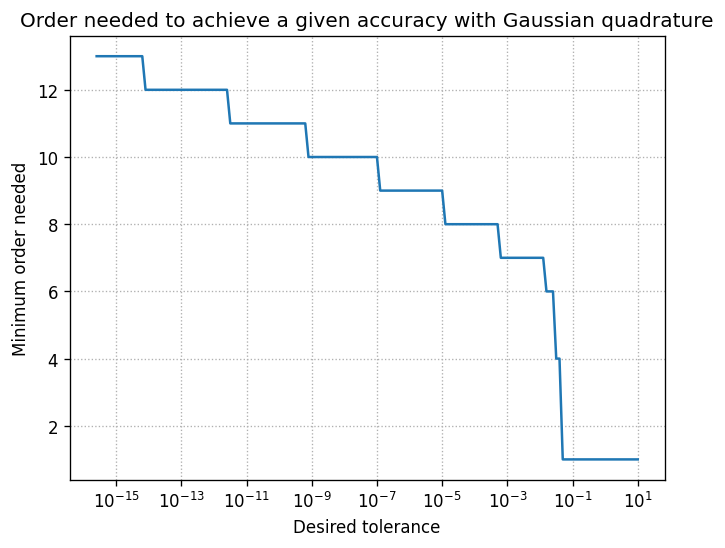

In [15]:
# For fun
tols = np.logspace(-17,1,181)
mask = tols > np.finfo(float).eps
tols = tols[mask]
best_ns = []
for tol in tols:
    best_n, best_I, best_err = find_min_order(f, 0, 1, true_result, tol, 200)
    best_ns.append(best_n)

plt.semilogx(tols, best_ns)
plt.xlabel("Desired tolerance")
plt.ylabel("Minimum order needed")
plt.title("Order needed to achieve a given accuracy with Gaussian quadrature")
plt.grid(True, which='both', ls=':')
plt.show()